In [1]:
import pandas as pd
import numpy as np
import random
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import base64
from io import BytesIO

In [2]:
class competitor:
    def __init__(self, owner, number, color):
        self.owner = owner
        self.number = number
        self.color = color
        self.still_playing = True
        self.piece_list = [
            self.number * np.array([[[1,1,1,1]], [[0,0,0,0]]]),
            self.number * np.array([[[1,1,1]], [[0,0,0]]]),
            self.number * np.array([[[1,1]], [[0,0]]]),
            self.number * np.array([[[1,0,0], [1,1,1]], [[0,0,0],[0,0,0]]]),
            self.number * np.array([[[1,1],[1,1]], [[0,0],[0,0]]]),
            self.number * np.array([[[1, 0],[1, 1]], [[0, 0],[0, 0]]]),
            self.number * np.array([[[0,1,0],[1,1,1]], [[0,0,0],[0,0,0]]]),
            self.number * np.array([[[0,1,1],[1,1,0]], [[0,0,0],[0,0,0]]]),
            self.number * np.array([[[1,0],[1,1]], [[0,0],[1,0]]]),
            self.number * np.array([[[1,0],[1,1]], [[0,0],[0,1]]]),
            self.number * np.array([[[0,1],[1,1]], [[0,0],[1,0]]])
        ]        
        self.piece_names_list = [
            '4x1','3x1','2x1','L','square','corner','pipe','bend','archer','twistL','twistR'
        ]

In [3]:
class board:
    def __init__(self, board):
        if board.lower() == 'chullpa':
            self.grid = np.zeros((8, 4, 5))
            self.aspect_ratio = [1, 1, 1.55]
        elif board.lower() == 'pirka':
            self.grid = np.zeros((4, 8, 6))
            self.grid[:, 3:, :3] = -1
            self.aspect_ratio = [1, 1.7, 0.7]
        elif board.lower() == 'coricancha':
            self.grid = np.zeros((4, 8, 8))
            self.grid[1:, 0, :] = -1
            self.grid[1:, 7, :] = -1
            self.grid[1:, :, 0] = -1
            self.grid[1:, :, 7] = -1
            self.grid[2:, 1, 1:7] = -1
            self.grid[2:, 6, 1:7] = -1
            self.grid[2:, 1:7, 1] = -1
            self.grid[2:, 1:7, 6] = -1
            self.grid[3:, 2, 2:6] = -1
            self.grid[3:, 5, 2:6] = -1
            self.grid[3:, 2:6, 2] = -1
            self.grid[3:, 2:6, 5] = -1
            self.aspect_ratio = [1, 1.3, 0.5]
        elif board.lower() == 'pisac':
            self.grid = np.zeros((8, 8, 8))
            self.grid[:, 0:6, 0] = -1
            self.grid[:, 0:6, 7] = -1
            self.grid[:, 0:4, 1] = -1
            self.grid[:, 0:4, 6] = -1
            self.grid[:, 0:2, 2] = -1
            self.grid[:, 0:2, 5] = -1
            self.grid[1:, 7, :] = -1
            self.grid[2:, 6, :] = -1
            self.grid[3:, 5, :] = -1
            self.grid[4:, 4, :] = -1
            self.grid[5:, 3, :] = -1
            self.grid[6:, 2, :] = -1
            self.grid[7:, 1, :] = -1
            self.aspect_ratio = [1, 1.3, 1]
        elif board.lower() == 'cucho':
            self.grid = np.zeros((5, 8, 8))
            self.grid[:, 0:4, 0:4] = -1
            self.grid[1:, 0, 4:] = -1
            self.grid[2:, 1, 4:] = -1
            self.grid[3:, 2, 4:] = -1
            self.grid[4:, 3, 4:] = -1
            self.grid[1:, 4:, 0] = -1
            self.grid[2:, 4:, 1] = -1
            self.grid[3:, 4:, 2] = -1
            self.grid[4:, 4:, 3] = -1
            self.aspect_ratio = [1, 1.35, 0.7]
        elif board.lower() == 'tambo':
            self.grid = np.zeros((4, 7, 7))
            self.grid[:, :2, 5:] = -1
            self.grid[:, 5:, :2] = -1
            self.grid[:, 2, 2] = -1
            self.aspect_ratio = [1, 1.35, 0.55]
            
            
    def draw_board(self, title_string):
        # grid_t = self.grid.transpose((2,1,0))
        grid_t = np.rot90(np.rot90(self.grid, k=1, axes=(0,2)), k=3, axes=(0,1))
        grid_t = np.where(grid_t == -1, 0, grid_t)

        color = []
        for i, layer in enumerate(grid_t):
            for j, row in enumerate(layer):
                for k, val in enumerate(row):
                    if val == 0:
                        color.append('none')
                    elif val == 1:
                        color.append('yellow')
                    elif val == 2:
                        color.append('red')
                    elif val == 3:
                        color.append('blue')
                    elif val == 4:
                        color.append('green')
        df = pd.DataFrame({'color':color})

        ax = plt.figure().add_subplot(projection='3d')
        fig = ax.voxels(grid_t, facecolors=np.array(df.color).reshape(grid_t.shape), edgecolor='k')

        ax.set_box_aspect(self.aspect_ratio)

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

        ax.set_title(title_string)

        return fig
    
    
    def get_results(self):
        grid = self.grid
        grid = np.where(grid == -1, 0, grid)
        missing = np.ones((grid.shape[1], grid.shape[2]))
        count_dict = {}
        for team in np.unique(grid):
            count_dict[team] = 0

        for i in range(1, grid.shape[0]+1):
            # Grab layer, only keep spots with no higher piece, count points
            layer = grid[i*-1, :, :]
            layer = layer*missing
            unique, counts = np.unique(layer, return_counts=True)
            layer_count_dict = dict(zip(unique, counts))
            # Add to team's point totals
            for team in layer_count_dict.keys():
                count_dict[team] = count_dict[team] + layer_count_dict[team]
            layer_missing = np.where(grid[i*-1, :, :] == 0, 1, 0)
            missing = missing * layer_missing

        # Put together result string
        count_dict.pop(-1, None)
        count_dict.pop(0, None)
        winner = int(max(count_dict, key=count_dict.get))
        result_str = f'Player {winner} Wins!!!\n'
        for player in count_dict.keys():
            result_str += f'\nPlayer {int(player)}: {count_dict[player]}'
        return result_str

In [6]:
def orient(piece):
    k1 = random.randint(0,3)
    k2 = random.randint(0,3)
    k3 = random.randint(0,3)
    return np.rot90(np.rot90(np.rot90(piece, k=k1, axes=(0,1)), k=k2, axes=(1,2)), k=k3, axes=(0,2))


def fill_out(piece, grid):
    n_layers, n_rows, n_columns = grid.shape
    stacks, rows, cols = piece.shape

    stack_max_start = n_layers-stacks
    row_max_start = n_rows-rows
    col_max_start = n_columns-cols

    stack_start = random.randint(0, stack_max_start)
    row_start = random.randint(0, row_max_start)
    col_start = random.randint(0, col_max_start)
    
    stack_top_pad = stack_start
    stack_bottom_pad = stack_max_start - stack_start
    row_top_pad = row_start
    row_bottom_pad = row_max_start - row_start
    col_left_pad = col_start
    col_right_pad = col_max_start - col_start

    return np.pad(piece,((stack_top_pad,stack_bottom_pad),(row_top_pad,row_bottom_pad),(col_left_pad,col_right_pad)))


def check_adjacent(grid, layer, player, turn_2=False):    
    n_layers, n_rows, n_columns = grid.shape
    
    adjacent = np.zeros((n_layers, n_rows, n_columns))

    for i, level in enumerate(grid):
        for j, row in enumerate(level):
            for k, val in enumerate(row):
                
                player_check = (val > 0) if turn_2 is True else (val == player)
                if player_check:

                    # Spots above current spots
                    if (i < (n_layers-1)) and (grid[i+1, j, k] == 0):
                        adjacent[i+1, j, k] = player

                    # Spots above/below current spots
                    if (j > 0) and (grid[i, j-1, k] == 0):
                        adjacent[i, j-1, k] = player
                    if (j < (n_rows-1)) and (grid[i, j+1, k] == 0):
                        adjacent[i, j+1, k] = player

                    # Spots left/right of current spots
                    if (k > 0) and (grid[i, j, k-1] == 0):
                        adjacent[i, j, k-1] = player
                    if (k < (n_columns-1)) and (grid[i, j, k+1] == 0):
                        adjacent[i, j, k+1] = player
                    
    adjacent_bool = False if (adjacent*layer).max() == 0 else True
    return adjacent, adjacent_bool


def check_nothanging(grid, layer, player):
    new_grid = grid + layer
    
    for i, level in enumerate(new_grid):
            for j, row in enumerate(level):
                for k, val in enumerate(row):
                    if val == player:
                        # Spots below cant be empty
                        if (i > 0) and (new_grid[i-1, j, k] == 0):
                            return False
    return True
    
    
def play_move(player, grid, start, turn_2):
    
    attempt_counter = 0
    
#     if player.owner == 'human':
#         a = input('piece')
    
    while True:
    
        # Randomly choose a piece
        piece_i = random.randint(0, len(player.piece_list)-1)
        piece = player.piece_list[piece_i]

        # Randomly rotate piece and place it's location
        oriented_piece = orient(piece)
        layer = fill_out(oriented_piece, grid.grid)

        # Check if it is a legal move
        
        # Are any spots already taken/void?
        if ((grid.grid*layer).max() == 0) and ((grid.grid*layer).min() == 0):
            spot_bool = True
        else:
            spot_bool = False

        # Check if adjacent to opponent piece (second piece only)
        if turn_2 is True:
            adjacent, adjacent_bool = check_adjacent(grid.grid, layer, player.number, turn_2=True)
        # Check if adjacent to an existing piece (unless it's the first turn)
        elif (spot_bool is True) and (start is False):
            adjacent, adjacent_bool = check_adjacent(grid.grid, layer, player.number)
        # The first piece doesn't have a rule
        else:
            adjacent_bool = True
            adjacent = ''
        
        # Check that the piece is not hanging
        if (spot_bool is True) and (adjacent_bool is True):
            nothanging_bool = check_nothanging(grid.grid, layer, player.number)
        else:
            nothanging_bool = False
        
        # Make that play if it is legal
        if (spot_bool is True) and (adjacent_bool is True) and (nothanging_bool is True):
            grid.grid += layer
            del player.piece_list[piece_i]
            piece_name = player.piece_names_list.pop(piece_i)
            
            return grid, piece_name
        
        # Keep track of attempts
        attempt_counter+=1
        if attempt_counter==5000:
            player.still_playing = False
            return grid, None

In [5]:
def play_game(num_players, board_name):

    p1 = competitor('cp', 1, 'yellow')
    p2 = competitor('cp', 2, 'red')
    p3 = competitor('cp', 3, 'blue')
    p4 = competitor('human', 4, 'green')
    players = {1: p1, 2: p2, 3: p3, 4: p4}

    grid = board(board_name)
    
    # Play
    i = 0
    while i <= 50:
        # Figure out whose turn it is and get their available pieces
        player_num = (i % num_players) + 1
        player = players[player_num]

        turn_2 = True if (i > 0) and (i < num_players) else False

        # Indicate if it's the player's first turn
        start = True if i<=1 else False

        # Play a piece
        if (player.still_playing is True) and (len(player.piece_list) > 0):
            grid, piece_name = play_move(player, grid, start, turn_2)
            if piece_name is None:
                title_string = f'Player {player_num} Maxed Out Attempts'
                fig = grid.draw_board(title_string)
            else:
                title_string = f'Player {player_num} Turn {i+1}: {piece_name}'
                fig = grid.draw_board(title_string)
            plt.show
        if (player.still_playing is True) and (len(player.piece_list)) == 0:
            title_string = f'Player {player_num} Out of Pieces'
            fig = grid.draw_board(title_string)
            player.still_playing = False
            plt.show

        i+=1

    print(grid.get_results())
        
    return fig, grid

C:\Users\Owner\AppData\Local\Temp\ipykernel_7236\3447706364.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax = plt.figure().add_subplot(projection='3d')


Player 4 Wins!!!

Player 1: 3
Player 2: 3
Player 3: 3
Player 4: 8


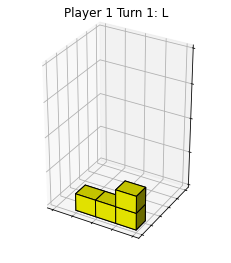

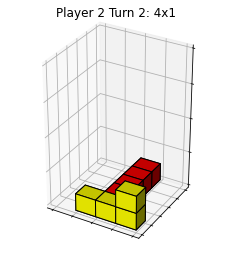

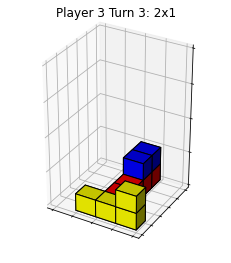

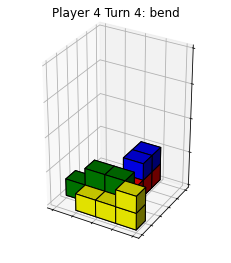

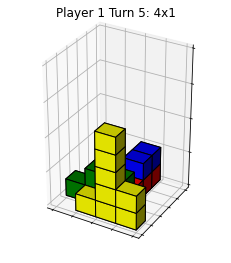

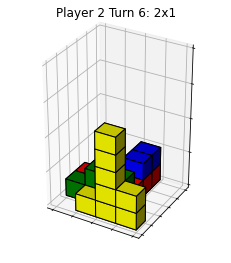

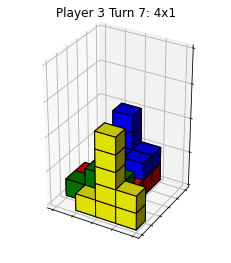

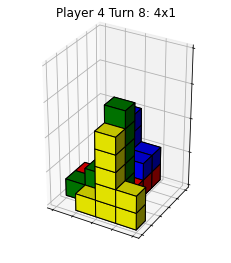

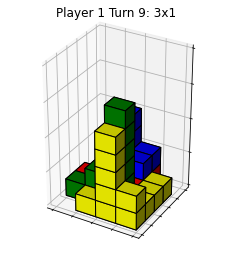

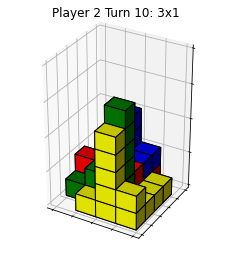

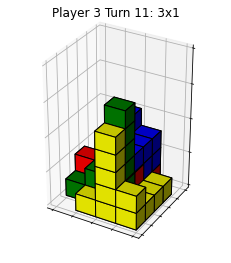

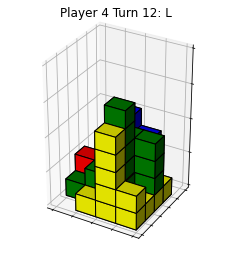

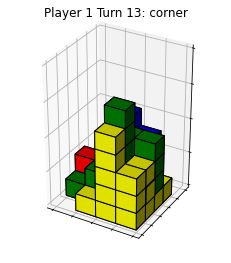

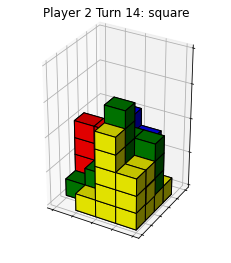

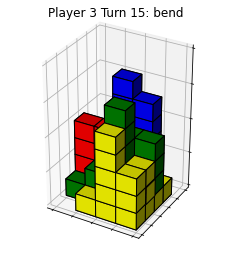

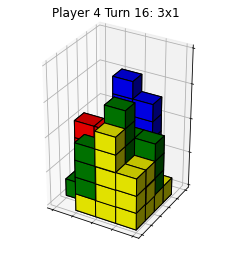

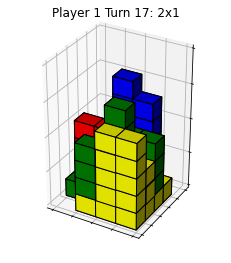

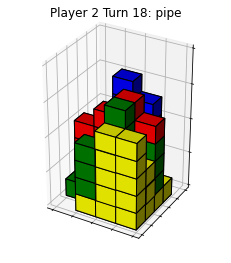

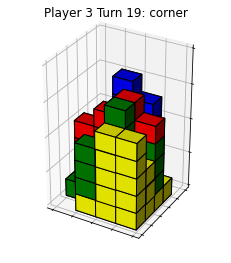

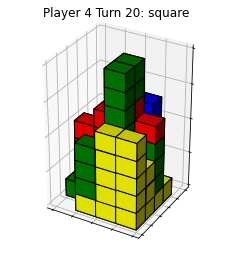

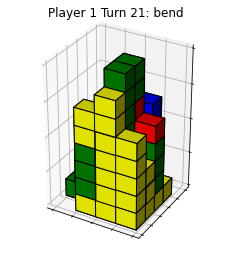

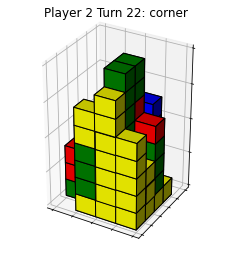

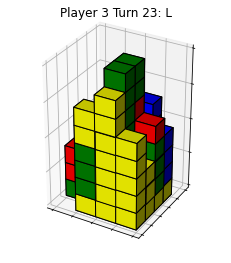

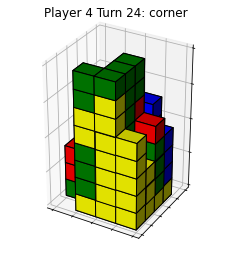

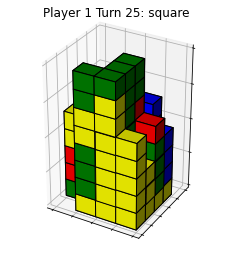

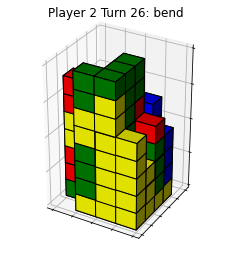

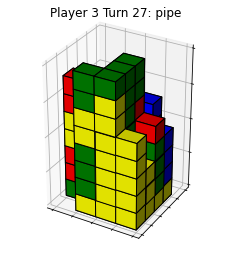

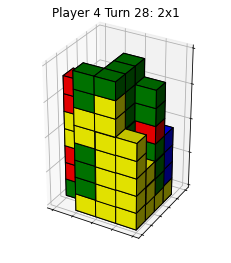

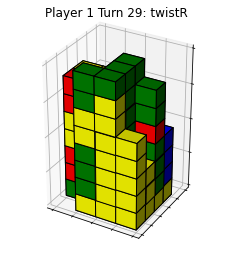

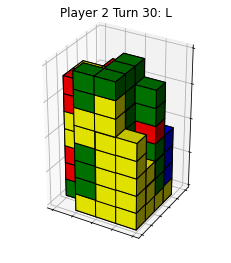

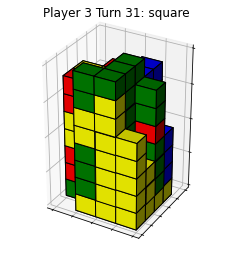

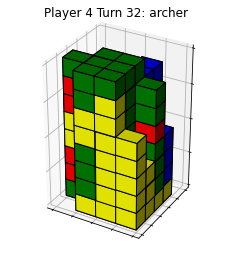

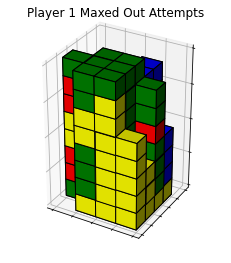

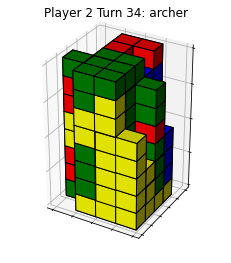

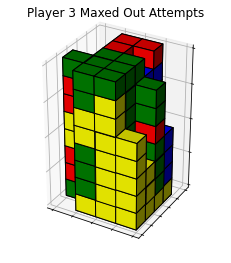

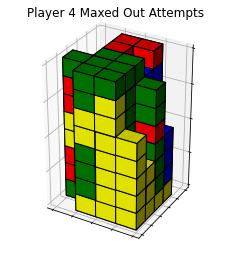

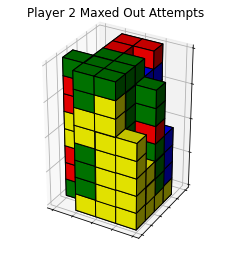

In [7]:
fig, grid = play_game(4, 'chullpa')

In [8]:
grid.grid

array([[[0., 4., 2., 3., 0.],
        [1., 4., 2., 3., 3.],
        [1., 2., 2., 2., 2.],
        [1., 1., 1., 1., 0.]],

       [[0., 2., 2., 3., 0.],
        [4., 4., 2., 3., 3.],
        [1., 4., 2., 3., 3.],
        [1., 1., 4., 3., 0.]],

       [[0., 2., 2., 3., 0.],
        [4., 2., 2., 3., 3.],
        [1., 4., 3., 3., 3.],
        [1., 1., 4., 3., 0.]],

       [[0., 1., 2., 0., 0.],
        [4., 1., 2., 3., 3.],
        [1., 4., 4., 3., 3.],
        [1., 0., 4., 3., 0.]],

       [[0., 1., 2., 0., 0.],
        [1., 1., 2., 2., 3.],
        [1., 4., 2., 2., 3.],
        [1., 0., 2., 0., 0.]],

       [[0., 2., 2., 0., 0.],
        [1., 1., 1., 2., 3.],
        [1., 4., 2., 3., 3.],
        [0., 0., 4., 0., 0.]],

       [[0., 2., 1., 0., 0.],
        [4., 4., 1., 2., 2.],
        [1., 4., 4., 3., 3.],
        [0., 0., 4., 0., 0.]],

       [[0., 4., 0., 0., 0.],
        [4., 4., 4., 2., 2.],
        [4., 4., 4., 0., 2.],
        [0., 0., 0., 0., 0.]]])

In [36]:
def fill_out2(piece, grid, row, col, stack):
    n_layers, n_rows, n_columns = grid.shape
    print(n_layers, n_rows, n_columns)
    stacks, rows, cols = piece.shape
    print(stacks, rows, cols)

    stack_max_start = n_layers-stacks
    row_max_start = n_rows-rows
    col_max_start = n_columns-cols
    print(stack_max_start, row_max_start, col_max_start)

#     stack_start = random.randint(0, stack_max_start)
#     row_start = random.randint(0, row_max_start)
#     col_start = random.randint(0, col_max_start)
    
    stack_top_pad = stack
    stack_bottom_pad = stack_max_start - stack
    row_top_pad = row
    row_bottom_pad = row_max_start - row
    col_left_pad = col
    col_right_pad = col_max_start - col

    return np.pad(piece,((stack_top_pad,stack_bottom_pad),(row_top_pad,row_bottom_pad),(col_left_pad,col_right_pad)))

In [51]:
# piece = orient(np.array([[[1,1]], [[0,0]]]))
piece = orient(np.array([[[1,1]]]))
piece

array([[[1]],

       [[1]]])

In [52]:
layer = fill_out2(piece, grid.grid, 3, 0, 5)
layer

8 4 5
2 1 1
6 3 4


array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]])

In [53]:
grid2 = grid.grid + layer

[Text(0.0, 0, ''),
 Text(1.0, 0, ''),
 Text(2.0, 0, ''),
 Text(3.0, 0, ''),
 Text(4.0, 0, ''),
 Text(5.0, 0, ''),
 Text(6.0, 0, ''),
 Text(7.0, 0, ''),
 Text(8.0, 0, '')]

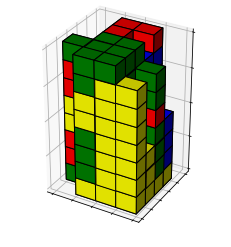

In [54]:
grid_t = np.rot90(np.rot90(grid2, k=1, axes=(0,2)), k=3, axes=(0,1))
grid_t = np.where(grid_t == -1, 0, grid_t)

color = []
for i, layer in enumerate(grid_t):
    for j, row in enumerate(layer):
        for k, val in enumerate(row):
            if val == 0:
                color.append('none')
            elif val == 1:
                color.append('yellow')
            elif val == 2:
                color.append('red')
            elif val == 3:
                color.append('blue')
            elif val == 4:
                color.append('green')
df = pd.DataFrame({'color':color})

ax = plt.figure().add_subplot(projection='3d')
fig = ax.voxels(grid_t, facecolors=np.array(df.color).reshape(grid_t.shape), edgecolor='k')

ax.set_box_aspect([1, 1, 1.55])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

Text(0.5, 0.92, 'testing')

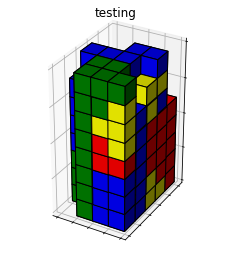

In [11]:
# grid_t = grid.grid.transpose((2,1,0))
grid_t = np.rot90(np.rot90(grid.grid, k=1, axes=(0,2)), k=3, axes=(0,1))
grid_t = np.where(grid_t == -1, 0, grid_t)

color = []
for i, layer in enumerate(grid_t):
    for j, row in enumerate(layer):
        for k, val in enumerate(row):
            if val == 0:
                color.append('none')
            elif val == 1:
                color.append('yellow')
            elif val == 2:
                color.append('red')
            elif val == 3:
                color.append('blue')
            elif val == 4:
                color.append('green')
df = pd.DataFrame({'color':color})

ax = plt.figure().add_subplot(projection='3d')
fig = ax.voxels(grid_t, facecolors=np.array(df.color).reshape(grid_t.shape), edgecolor='k')

ax.set_box_aspect([1.4, 2, 2.8])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_title('testing')

Text(0.5, 0.92, 'testing')

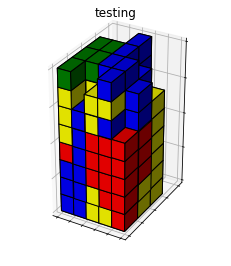

In [15]:
# grid_t = grid.grid.transpose((2,1,0))
grid_t = np.rot90(np.rot90(grid.grid, k=1, axes=(0,2)), k=2, axes=(0,1))
grid_t = np.where(grid_t == -1, 0, grid_t)

color = []
for i, layer in enumerate(grid_t):
    for j, row in enumerate(layer):
        for k, val in enumerate(row):
            if val == 0:
                color.append('none')
            elif val == 1:
                color.append('yellow')
            elif val == 2:
                color.append('red')
            elif val == 3:
                color.append('blue')
            elif val == 4:
                color.append('green')
df = pd.DataFrame({'color':color})

ax = plt.figure().add_subplot(projection='3d')
fig = ax.voxels(grid_t, facecolors=np.array(df.color).reshape(grid_t.shape), edgecolor='k')

ax.set_box_aspect([1.4, 2, 2.8])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.set_title('testing')

In [ ]:
if board.lower() == 'chullpa':
    self.aspect_ratio = [1, 1, 1.55]
elif board.lower() == 'pirka':
    self.aspect_ratio = [1, 1.7, 0.7]
elif board.lower() == 'coricancha':
    self.aspect_ratio = [1, 1.3, 0.5]
elif board.lower() == 'pisac':
    self.aspect_ratio = [1, 1.3, 1]
elif board.lower() == 'cucho':
    self.aspect_ratio = [1, 1.35, 0.7]
elif board.lower() == 'tambo':
    self.aspect_ratio = [1, 1.35, 0.55]